# Practical 3: CIFAR-10

This is the second task of Practical 3. Your task is to use **transfer learning** to build a convolutional neural network to tackle the CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). 
You could select an existing trained model (VGG16 excluded) from Keras (https://keras.io/api/applications/) and fine-tune it to build a classifier for CIFAR-10.

We will mark your code based on the accuracy of your model. 
Your CNN should achieve at least an accuracy of 75% to pass the practical.
You can get 5 or 10 bonus points by achieving an accuracy of 85%+ or 90%+.

You should save and upload your model to the seafile link we provided to you. Please name the model file as `{repository_name}-CIFAR10.h5`. For example, if your repository is FDS21-M0, you should name the model file as `FDS21-M0-CIFAR10.h5`

## Import the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [2]:
tf.__version__

'2.6.2'

In [3]:
tf.keras.__version__

'2.6.0'

## Prepare the dataset

In this block, you will prepare the data for the training, such as apply the preprocess function of your selected model and perform data augmentation. 

170508288/170498071 [==============================] - 11s 0us/step


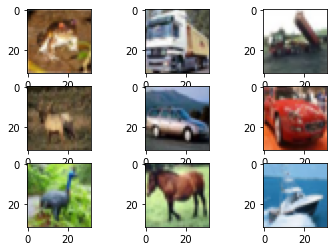

(50000, 32, 32, 3)

In [4]:
from keras.datasets import cifar10
from PIL import Image
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train_full[i])
plt.show()

X_train_full.shape

In [5]:
from keras.applications.densenet import preprocess_input

X_train_full = preprocess_input(X_train_full)
print(X_train_full.shape)
X_test = preprocess_input(X_test)

# one-hot encoding
y_train_full = keras.utils.to_categorical(y_train_full, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

# get validation dataset
np.random.seed(42) # we set the random seed to make sure everytime the data is shuffled in the same way 
shuffled_indices = np.random.permutation(X_train_full.shape[0])
X_valid, X_train = X_train_full[shuffled_indices[:5000]], X_train_full[shuffled_indices[5000:]]
y_valid, y_train = y_train_full[shuffled_indices[:5000]], y_train_full[shuffled_indices[5000:]]

(50000, 32, 32, 3)


## Build and train the model

Build and train your model. 

In [15]:
# TODO: load the model you selected

inputs = keras.Input(shape=(32, 32, 3))
# upscale layer
upscale = keras.layers.Lambda(lambda x: tf.image.resize_with_pad(x, 160, 160, method=tf.image.ResizeMethod.BILINEAR))(inputs)

#base_model = tf.keras.applications.densenet.DenseNet169(include_top=False, input_shape=(32,32, 3), weights='imagenet')
base_model = tf.keras.applications.DenseNet169(include_top=False, input_tensor=upscale,
                                        input_shape=(160,160,3),
                                        pooling='max')
#base_model.summary()

# TODO: Transfer learning - build your own model based on the selected model
x = base_model.layers[-3].output
x = keras.layers.Flatten()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256,activation='relu')(x) 
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(128,activation='relu')(x) 
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.3)(x)
output = keras.layers.Dense(units=10, activation='softmax')(x)
model = keras.Model(inputs = base_model.input, outputs = output)

for layer in base_model.layers:
  layer.trainable=False

In [7]:
# show the structure of your model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 160, 160, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 166, 166, 3)  0           lambda[0][0]                     
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 80, 80, 64)   9408        zero_padding2d[0][0]             
______________________________________________________________________________________________

In [8]:
model.compile(optimizer=keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [9]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=2, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False)
history = model.fit(X_train_full, y_train_full, batch_size=64, epochs=15, validation_data=(X_valid, y_valid),callbacks=[callback])

2021-12-31 19:03:36.625367: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2021-12-31 19:03:45.107704: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


782/782 [==============================] - 83s 88ms/step - loss: 0.4021 - accuracy: 0.8679 - val_loss: 0.1574 - val_accuracy: 0.9492
Epoch 2/15
782/782 [==============================] - 70s 89ms/step - loss: 0.2470 - accuracy: 0.9172 - val_loss: 0.0966 - val_accuracy: 0.9710
Epoch 3/15
782/782 [==============================] - 65s 84ms/step - loss: 0.1882 - accuracy: 0.9360 - val_loss: 0.0663 - val_accuracy: 0.9794
Epoch 4/15
782/782 [==============================] - 65s 83ms/step - loss: 0.1486 - accuracy: 0.9488 - val_loss: 0.0498 - val_accuracy: 0.9870
Epoch 5/15
782/782 [==============================] - 65s 84ms/step - loss: 0.1252 - accuracy: 0.9575 - val_loss: 0.0385 - val_accuracy: 0.9894
Epoch 6/15
782/782 [==============================] - 66s 84ms/step - loss: 0.1003 - accuracy: 0.9654 - val_loss: 0.0310 - val_accuracy: 0.9914
Epoch 7/15
782/782 [==============================] - 71s 91ms/step - loss: 0.0927 - accuracy: 0.9667 - val_loss: 0.0232 - val_accuracy: 0.9926
Epo

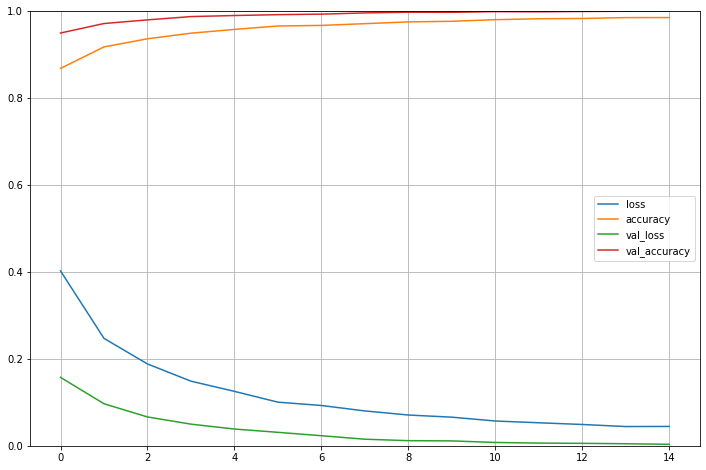

In [10]:
# Assume you have stored the training history in the variable "history"
# Show the learning curves
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.gca().set_ylim(0, 1)
plt.grid(True)
plt.show()

## Save the model

Save and upload your trained model to the seafile link we provided to you. You can upload it multiple times. We will consider only the newest uploaded model. 

In [13]:
# change the file name according to your repository name
model.save('FDS21-M62-CIFAR10.h5')

## Load the model and evaluate it on the test data

In [12]:
model = keras.models.load_model('FDS21-M62-CIFAR10.h5')
model.evaluate(X_test, y_test)

313/313 [==============================] - 14s 44ms/step - loss: 0.3443 - accuracy: 0.9246


[0.34425684809684753, 0.9246000051498413]

## Short report

Please write a few sentences explaining how you build and train the model. Please include the decisions you made, such as how you decide the number of layers reused from the selected model, and the difficulties you met.

Wanted to try Xception model but image size too small